# Training Notebook for Vanilla CNN in pytorch

This notebook is used to examine the performance of the GPU available locally. We perform a Cats and Dogs classification for the following test run

The following code is not an original work but is derived from the following [link](https://python.plainenglish.io/cat-dog-classification-with-cnn-84af3ae98c44)

Library Imports for the jupyter notebook

In [1]:
import os  # miscellaneous os interfaces
import sys  # configuring python runtime environment
import time  # library for time manipulation, and logging

In [2]:
# use `datetime` to control and preceive the environment
# in addition `pandas` also provides date time functionalities
import datetime as dt

In [3]:
from copy import deepcopy  # dataframe is mutable
from tqdm import tqdm  # progress bar for loops
from uuid import uuid4 as UUID  # unique identifier for objs

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchinfo import summary
from torch.utils.data import DataLoader
from torchsummary import summary

In [6]:
import opendatasets as od

In [7]:
import cv2

Check if cuda is available

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Preparation

In [9]:
def load_images(path):
    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        if filename == "_DS_Store":
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(100, 100))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

Run the following command to download the images to your current local folder and copy the downloaded folder under
the data -> processed folder

In [10]:
# od.download(
#     "https://www.kaggle.com/datasets/chetankv/dogs-cats-images")

In [11]:
cats_train = load_images(
    "../data/processed/dogs-cats-images/dog vs cat/dataset/training_set/cats"
)
dogs_train = load_images(
    "../data/processed/dogs-cats-images/dog vs cat/dataset/training_set/dogs"
)

cats_test = load_images(
    "../data/processed/dogs-cats-images/dog vs cat/dataset/test_set/cats"
)
dogs_test = load_images(
    "../data/processed/dogs-cats-images/dog vs cat/dataset/test_set/dogs"
)

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 980.00it/s]


In [12]:
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(4000, 100, 100, 3)
(4000, 100, 100, 3)
(1000, 100, 100, 3)
(1000, 100, 100, 3)


What we need to do next is to put all train and test data into the same array which can simply be achieved by using np.append() function. The codes written in Codeblock 6 below utilizes this function to concatenate the arrays along the 0-th axis. By doing so, now that we have all our training and testing images stored in X_train and X_test, respectively.

In [13]:
X_train = np.append(cats_train, dogs_train, axis=0)
X_test = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(8000, 100, 100, 3)
(2000, 100, 100, 3)


## Creating Labels
That was all for the images. The subsequent step to be done is to create a label for each of those images. The idea of this part is to label cats with 0 and dogs with 1.

The way to do it is pretty simple. Remember that the first 4000 images in X_train are cats and the remaining 4000 are dogs. By knowing this structure, we can create an array of zeros and ones with these lengths which are then concatenated the same way as what we have done with X_train. We will do the exact same thing to create labels for test data.

In [14]:
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(8000,)
(2000,)


## Displaying Several Images
As a side task, I will also create a function for displaying several images in our dataset. The function which I name show_images() accepts 3 parameters: images, labels, and start_index. The first two are basically an array of images and labels — which is pretty straightforward. Whereas start_index denotes the index of the images that we want to show first. The Codeblock 8 below shows what the function looks like.

In [15]:
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i, j].set_title(labels[counter].item())
            axes[i, j].imshow(images[counter], cmap="gray")
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

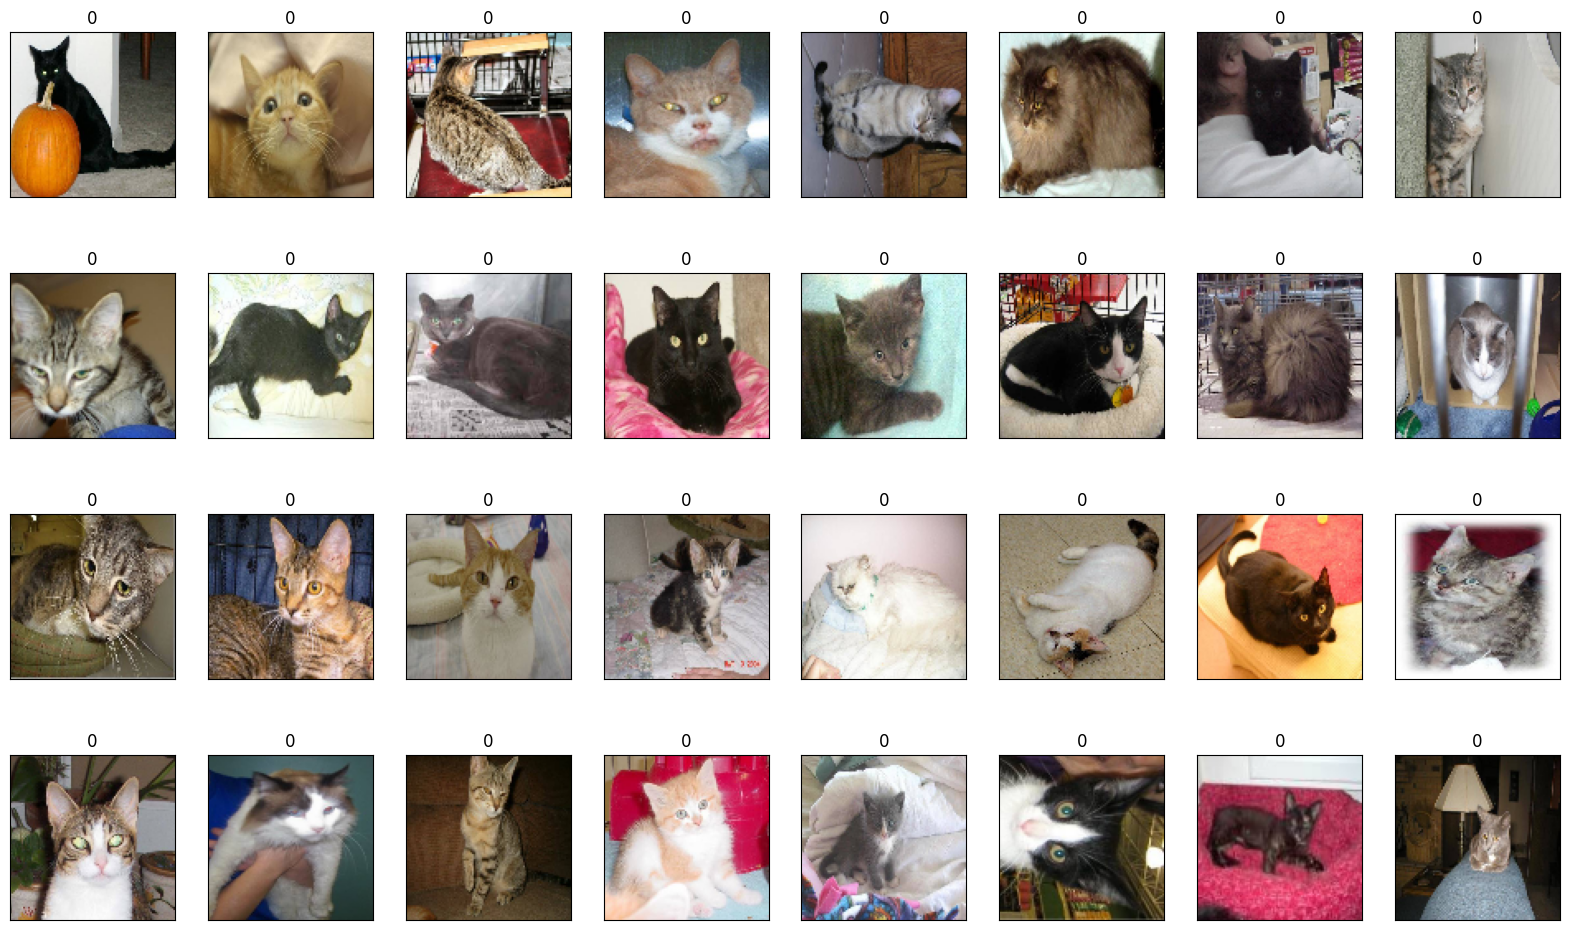

In [16]:
show_images(X_train, y_train, 0)

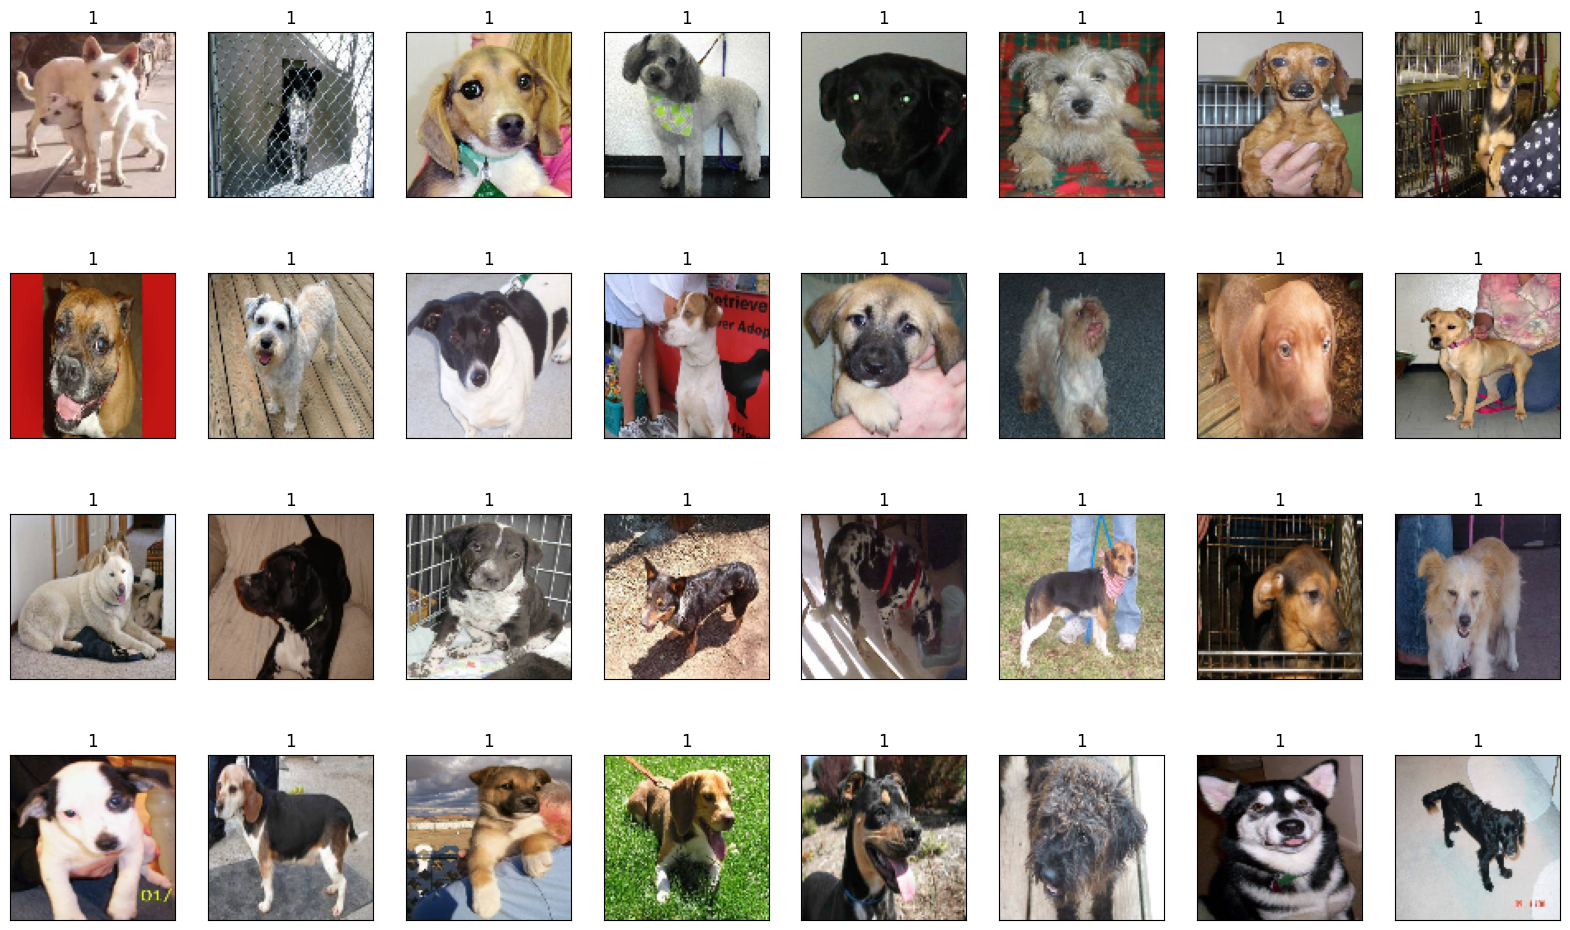

In [17]:
show_images(X_train, y_train, 4000)

In [18]:
print(y_train[:10])

[0 0 0 0 0 0 0 0 0 0]


Now that we need to put this to a 2-dimensional array using the following code. We also convert it to a Pytorch tensor afterwards.

In [19]:
# Codeblock 12
y_train = torch.from_numpy(y_train.reshape(len(y_train), 1))
y_test = torch.from_numpy(y_test.reshape(len(y_test), 1))

print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


## Image Preprocessing and Augmentation
The convenient part when working with Pytorch is that we can do image preprocessing and augmentation using a single function, namely transforms.Compose(). What we are doing with the Codeblock 13 below is that we will convert the images (which is originally in fom of a Numpy array) to Pytorch tensor. The pixel intensity values in the images are also squeezed to -1 and 1 only using transforms.Normalize(). It is important to know that I repeat the value for mean and standard deviation three times because the original image has RGB color channels. So basically, each element in the list corresponds to a single channel.

In [20]:
transforms_train = transforms.Compose(
    [
        transforms.ToTensor(),  # convert to tensor
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.005),
        transforms.RandomGrayscale(p=0.2),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),  # squeeze to -1 and 1
    ]
)

In [21]:
transforms_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

## Custom Dataset Class & Data Loader
The next step to do is that I am going to create a class to store the pair of images and labels. In fact, we can actually use TensorDataset class which is already available in Pytorch module. However, we will create a custom one instead since TensorDataset does not allow transforms.Compose objects to get passed, which causes us unable to do preprocessing and augmentation. The Codeblock 15 below shows what a custom class of Cat_Dog_Dataset looks like.

In [22]:
class Cat_Dog_Dataset:
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [23]:
train_dataset = Cat_Dog_Dataset(
    images=X_train, labels=y_train, transform=transforms_train
)
test_dataset = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

## Data Loader
Once train_dataset and test_dataset have been initialized, we need to create DataLoader for the two in order to determine how the data is going to get loaded. In our case, I decided to train a model with a batch size of 32. I also set the drop_last parameter to True in order to avoid the last batch to get fed into a model whenever it contains less than 32 images in it.

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [25]:
# For visualizing how dataloader works
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 100, 100])


On the other hand, when it comes to displaying an image, we need to convert the shape of the array back to the initial dimension. This can be achieved by using permute() method. Once it is done, we can now feed the image array (image_batch_permuted) to the show_images() function.

torch.Size([32, 100, 100, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

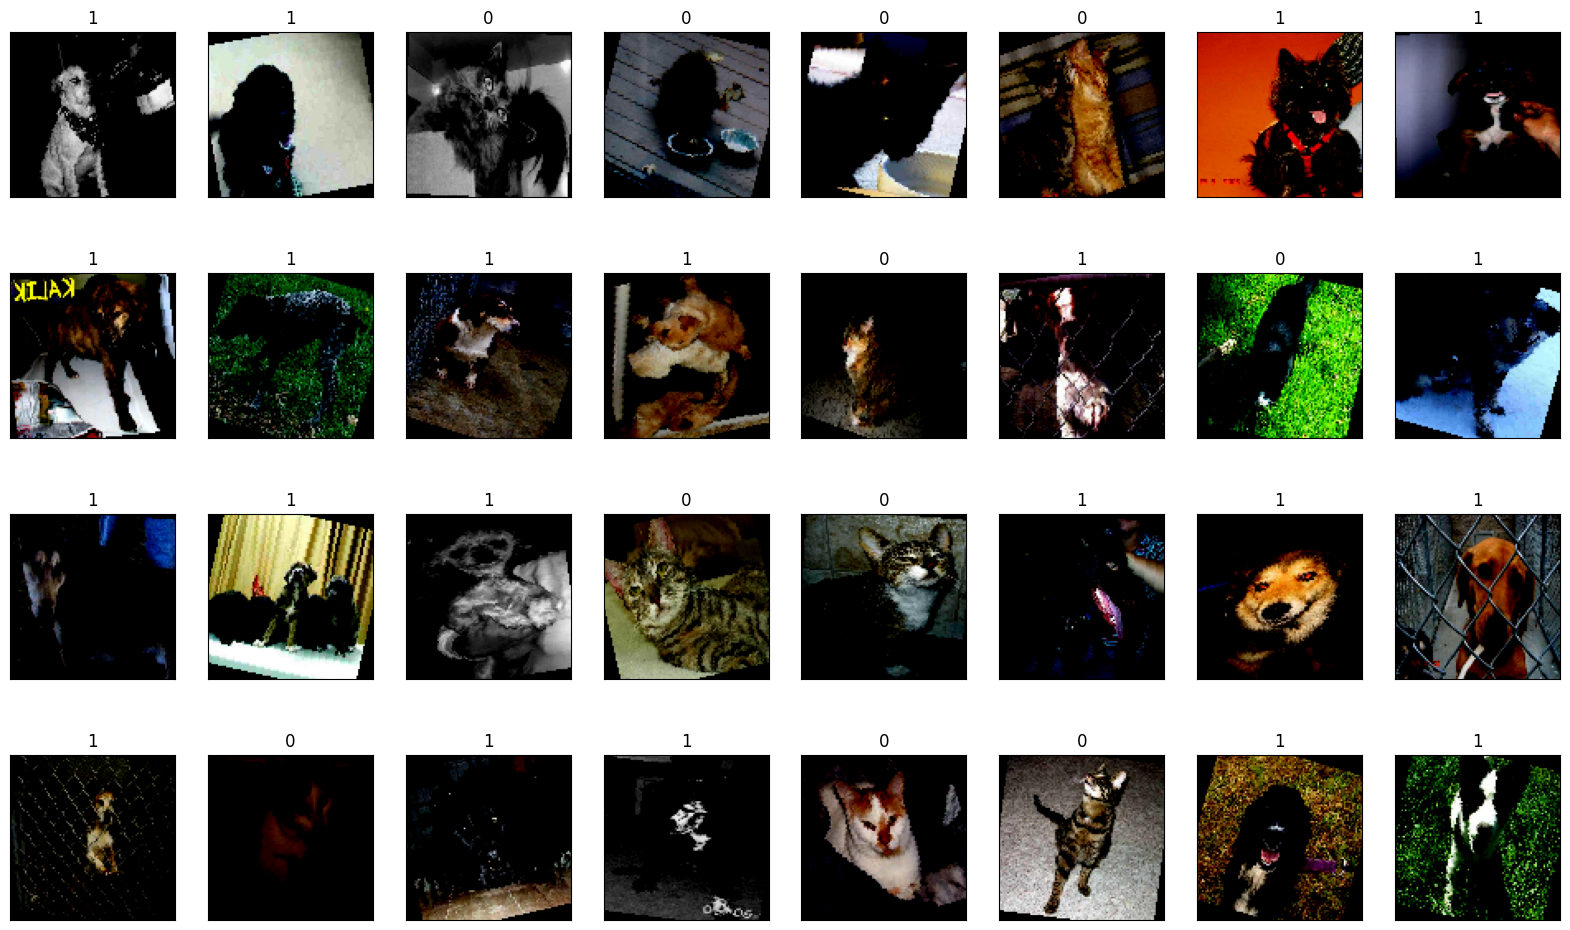

In [26]:
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

show_images(image_batch_permuted, label_batch, 0)

# Model

Create the CNN model

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv1 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # self.maxpool

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # self.maxpool

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(num_features=128)
        # self.maxpool

        self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128 * 6 * 6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)

        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        return x

In [28]:
model = CNN().to(device)
print(model)

CNN(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc0): Linear(in_features=4608, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_

In [29]:
summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             432
       BatchNorm2d-2         [-1, 16, 100, 100]              32
         MaxPool2d-3           [-1, 16, 50, 50]               0
            Conv2d-4           [-1, 32, 50, 50]           4,608
       BatchNorm2d-5           [-1, 32, 50, 50]              64
         MaxPool2d-6           [-1, 32, 25, 25]               0
            Conv2d-7           [-1, 64, 25, 25]          18,432
       BatchNorm2d-8           [-1, 64, 25, 25]             128
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10          [-1, 128, 12, 12]          73,728
      BatchNorm2d-11          [-1, 128, 12, 12]             256
        MaxPool2d-12            [-1, 128, 6, 6]               0
          Dropout-13                 [-1, 4608]               0
           Linear-14                   

#  Model Training


In [30]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [31]:
def predict_test_data(model, test_loader):
    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss = loss_function(test_preds, y_test)

            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)

    model.train()

    test_acc = num_correct / num_samples

    return test_loss, test_acc

In [32]:
train_losses = (
    []
)  # Training and testing loss was calculated based on the last batch of each epoch.
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(
        enumerate(train_loader), total=len(train_loader)
    ):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)

        # Forward propagation
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)

        # Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)

        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()

        # Gradient descent
        optimizer.step()

    train_acc = num_correct_train / num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())

    print(
        f"Epoch: {epoch} \t|"
        f" Train loss: {np.round(train_loss.item(),3)} \t|"
        f" Test loss: {np.round(test_loss.item(),3)} \t|"
        f" Train acc: {np.round(train_acc.item(),2)} \t|"
        f" Test acc: {np.round(test_acc.item(),2)}"
    )

100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:05<00:00, 49.86it/s]


Epoch: 0 	| Train loss: 0.564 	| Test loss: 0.446 	| Train acc: 0.66 	| Test acc: 0.73


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 50.64it/s]


Epoch: 1 	| Train loss: 0.468 	| Test loss: 0.409 	| Train acc: 0.75 	| Test acc: 0.78


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.70it/s]


Epoch: 2 	| Train loss: 0.415 	| Test loss: 0.554 	| Train acc: 0.77 	| Test acc: 0.78


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 51.87it/s]


Epoch: 3 	| Train loss: 0.303 	| Test loss: 0.497 	| Train acc: 0.8 	| Test acc: 0.83


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.92it/s]


Epoch: 4 	| Train loss: 0.422 	| Test loss: 0.536 	| Train acc: 0.8 	| Test acc: 0.84


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.77it/s]


Epoch: 5 	| Train loss: 0.645 	| Test loss: 0.222 	| Train acc: 0.82 	| Test acc: 0.85


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 51.65it/s]


Epoch: 6 	| Train loss: 0.245 	| Test loss: 0.318 	| Train acc: 0.83 	| Test acc: 0.84


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 53.05it/s]


Epoch: 7 	| Train loss: 0.187 	| Test loss: 0.285 	| Train acc: 0.84 	| Test acc: 0.81


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 53.10it/s]


Epoch: 8 	| Train loss: 0.32 	| Test loss: 0.217 	| Train acc: 0.85 	| Test acc: 0.87


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 51.74it/s]


Epoch: 9 	| Train loss: 0.185 	| Test loss: 0.569 	| Train acc: 0.85 	| Test acc: 0.77


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 51.35it/s]


Epoch: 10 	| Train loss: 0.253 	| Test loss: 0.14 	| Train acc: 0.86 	| Test acc: 0.87


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 51.45it/s]


Epoch: 11 	| Train loss: 0.215 	| Test loss: 0.214 	| Train acc: 0.87 	| Test acc: 0.88


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.75it/s]


Epoch: 12 	| Train loss: 0.289 	| Test loss: 0.281 	| Train acc: 0.87 	| Test acc: 0.88


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.27it/s]


Epoch: 13 	| Train loss: 0.237 	| Test loss: 0.397 	| Train acc: 0.87 	| Test acc: 0.88


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.66it/s]


Epoch: 14 	| Train loss: 0.412 	| Test loss: 0.186 	| Train acc: 0.88 	| Test acc: 0.89


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 53.16it/s]


Epoch: 15 	| Train loss: 0.244 	| Test loss: 0.456 	| Train acc: 0.88 	| Test acc: 0.86


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 53.29it/s]


Epoch: 16 	| Train loss: 0.297 	| Test loss: 0.141 	| Train acc: 0.88 	| Test acc: 0.89


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.32it/s]


Epoch: 17 	| Train loss: 0.263 	| Test loss: 0.266 	| Train acc: 0.89 	| Test acc: 0.89


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 52.51it/s]


Epoch: 18 	| Train loss: 0.255 	| Test loss: 0.197 	| Train acc: 0.89 	| Test acc: 0.9


100%|███████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 53.44it/s]


Epoch: 19 	| Train loss: 0.361 	| Test loss: 0.288 	| Train acc: 0.89 	| Test acc: 0.86


# Evaluation

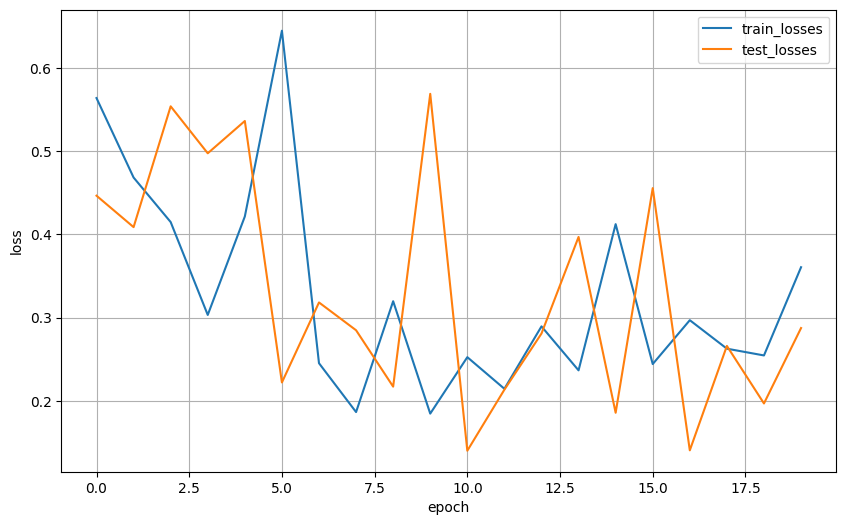

In [33]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["train_losses", "test_losses"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

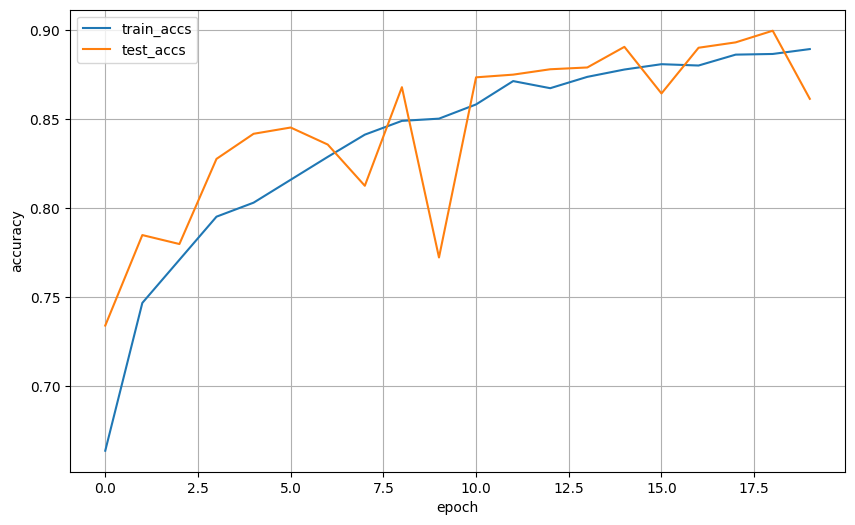

In [34]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(["train_accs", "test_accs"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

# Prediction

Predicting Images on Test Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

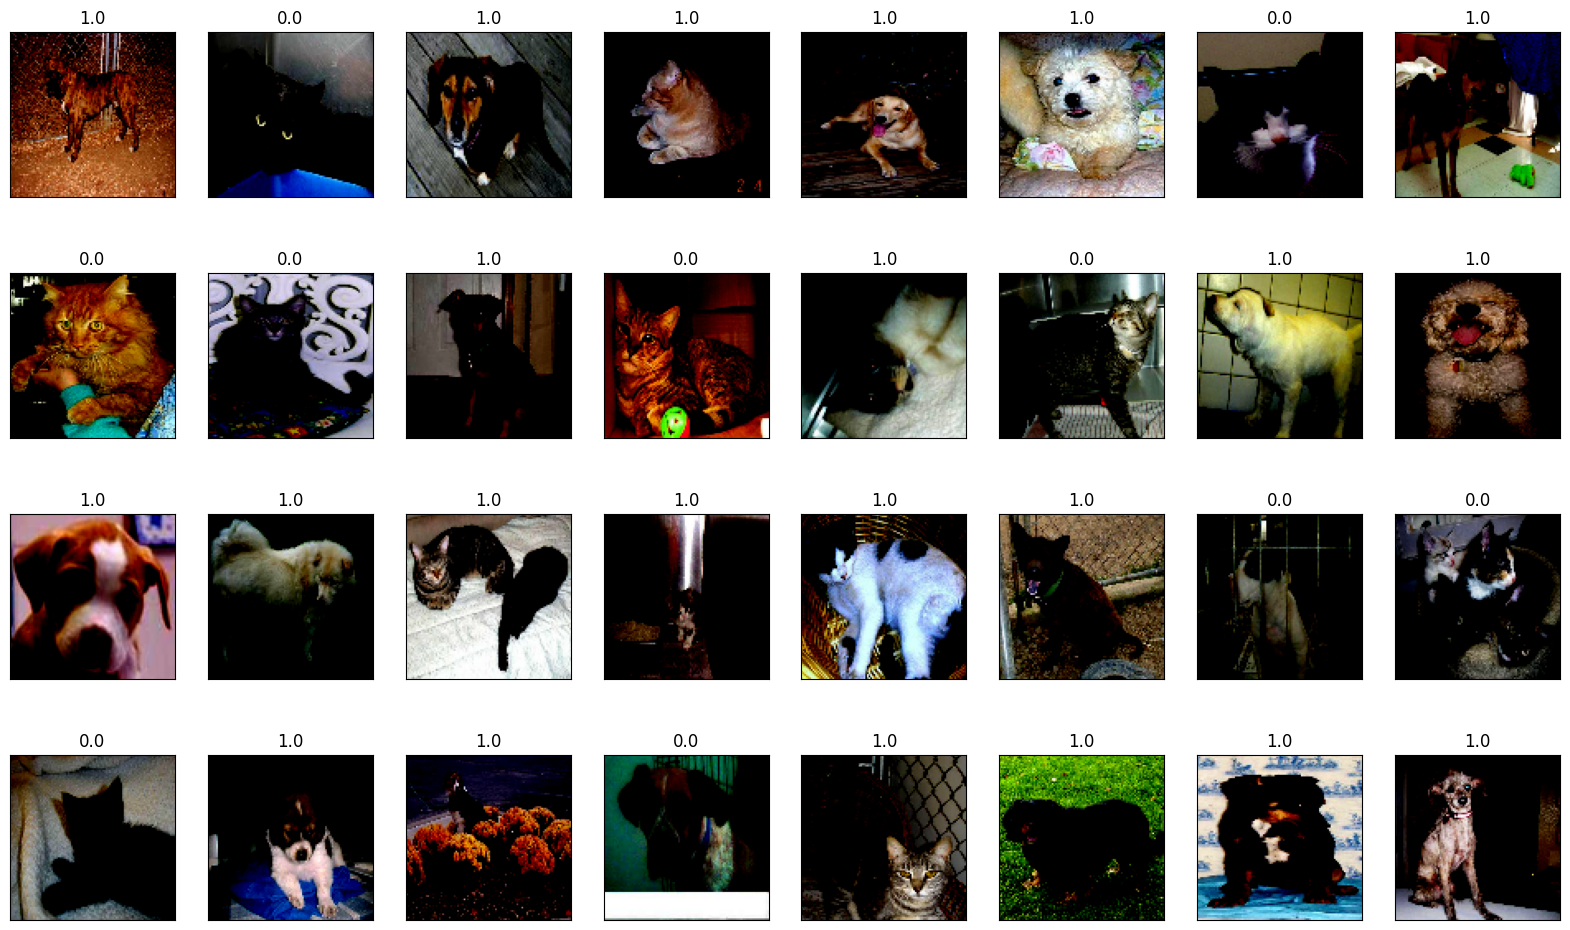

In [35]:
# Load test images
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(device))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)